# Training Chest X-ray Dataset

## 1. Data preprocessing

### 1.1 Text Dataset

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("./Dataset/train_data.csv")
train_data = train_data.drop("Unnamed: 0", axis=1)
train_data = train_data.fillna(0.0)
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,Images,Normal,COVID-19,BacterialPneumonia,ViralPneumonia
0,Normal/578.jpeg,1.0,0.0,0.0,0.0
1,COVID-19/rotated15_6_flipped_90degree.jpg,0.0,1.0,0.0,0.0
2,COVID-19/rotated15__46_3593431_180degree.jpg,0.0,1.0,0.0,0.0
3,COVID-19/rotated15_34_270degree.jpg,0.0,1.0,0.0,0.0
4,COVID-19/53_flipped.jpg,0.0,1.0,0.0,0.0


In [3]:
val_data = pd.read_csv("./Dataset/val_data.csv")
val_data = val_data.drop("Unnamed: 0", axis=1)
val_data = val_data.fillna(0.0)
val_data = val_data.sample(frac=1).reset_index(drop=True)
val_data.head()

,Images,Normal,COVID-19,BacterialPneumonia,ViralPneumonia
0,Normal/226.jpeg,1.0,0.0,0.0,0.0
1,BacterialPneumonia/197.jpeg,0.0,0.0,1.0,0.0
2,ViralPneumonia/191.jpeg,0.0,0.0,0.0,1.0
3,Normal/9.jpeg,1.0,0.0,0.0,0.0
4,ViralPneumonia/17.jpeg,0.0,0.0,0.0,1.0


In [4]:
X_files = train_data['Images']
V_files = val_data['Images']
y_train = train_data.iloc[:, 1: ]
y_val = val_data.iloc[:, 1:]
y_train = np.array(y_train)
y_val = np.array(y_val)

In [5]:
X = []
for index, img in tqdm(enumerate(X_files), total = len(X_files)):
    X.append("./Dataset/"+img)

X_val = []
for index, img in tqdm(enumerate(V_files), total = len(V_files)):
    X_val.append("./ValData/"+img)

100%|██████████| 988/988 [00:00<00:00, 988778.90it/s]


In [6]:
X[: 5]

['./Dataset/Normal/578.jpeg',
 './Dataset/COVID-19/rotated15_6_flipped_90degree.jpg',
 './Dataset/COVID-19/rotated15__46_3593431_180degree.jpg',
 './Dataset/COVID-19/rotated15_34_270degree.jpg',
 './Dataset/COVID-19/53_flipped.jpg']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.10, random_state=7)
print(len(X_train))
print(len(X_test))
print(len(X_val))

5768
641
988


### 1.2 Image dataset

In [8]:
# Importing libraries
import keras
from keras.preprocessing import image

In [9]:
# Converting a given image into tensor
def path_to_tensor(data_path):
    # Loading image
    img = image.load_img(data_path, target_size=(256, 256))
    # Converting image to array
    img = image.img_to_array(img)
    # Converting to 4D tensor => (1, 256, 256, 3)
    return np.expand_dims(img, axis=0)

In [10]:
# Getting a list of tensors
def path_to_tensors(data_paths):
    
    # List of tensors
    list_of_tensors = [path_to_tensor(path) for path in tqdm(data_paths)]
    return np.vstack(list_of_tensors)

In [11]:
train_tensors = path_to_tensors(X_train).astype('float32')/255.0
test_tensors = path_to_tensors(X_test).astype('float32')/255.0
val_tensors = path_to_tensors(X_val).astype('float')/255.0

100%|██████████| 988/988 [00:19<00:00, 49.64it/s] 


In [12]:
train_tensors.shape

(5768, 256, 256, 3)

## 2. Training the model

In [13]:
import keras
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Input, Average
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

### 2.1 MobileNet architecture

In [21]:
def mobilenet_architecture():
    '''
    Pre-trained mobile-net architecture for our dataset
    '''
    from keras.applications.mobilenet import MobileNet
    
    # Loading the base_model
    base_model = MobileNet(include_top=False, weights=None, input_shape=(256, 256, 3))
    
    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    output = Dense(units=4, activation='softmax')(x)

    # Creating the whole model
    mn_model = Model(base_model.input, output)
    
    # Summarizing the model
    mn_model.summary()
    
    # Compiling model
    mn_model.compile(optimizer = Adam(lr=0.001),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])
    
    return mn_model

In [22]:
mobilenet_model = mobilenet_architecture()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)     

In [30]:
checkpointer = ModelCheckpoint(filepath='./weights/mobilenet.hdf5', 
                               verbose=1, 
                               save_best_only=True)

mn_histoy = mobilenet_model.fit(train_tensors, 
                    y_train, 
                    batch_size = 64,
                    validation_data = (val_tensors, y_val),
                    epochs = 10,
                    callbacks=[checkpointer], 
                    verbose=1)

Epoch 1/10
91/91 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7212 
Epoch 00001: val_loss improved from inf to 1.53630, saving model to ./weights\mobilenet.hdf5
91/91 [==============================] - 1513s 17s/step - loss: 0.6812 - accuracy: 0.7212 - val_loss: 1.5363 - val_accuracy: 0.3279
Epoch 2/10
91/91 [==============================] - ETA: 0s - loss: 0.4309 - accuracy: 0.8242 
Epoch 00002: val_loss improved from 1.53630 to 1.51299, saving model to ./weights\mobilenet.hdf5
91/91 [==============================] - 1262s 14s/step - loss: 0.4309 - accuracy: 0.8242 - val_loss: 1.5130 - val_accuracy: 0.3279
Epoch 3/10
91/91 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8473 
Epoch 00003: val_loss did not improve from 1.51299
91/91 [==============================] - 1570s 17s/step - loss: 0.3568 - accuracy: 0.8473 - val_loss: 1.6505 - val_accuracy: 0.3279
Epoch 4/10
91/91 [==============================] - ETA: 0s - loss: 0.3299 - a

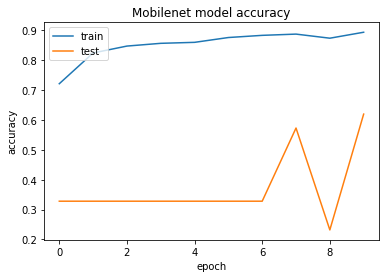

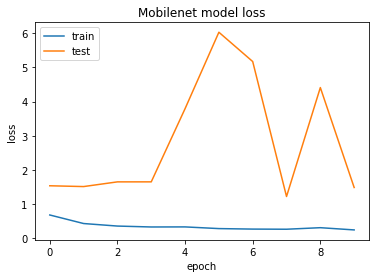

In [34]:
# summarize history for accuracy
plt.plot(mn_histoy.history['accuracy'])
plt.plot(mn_histoy.history['val_accuracy'])
plt.title('Mobilenet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(mn_histoy.history['loss'])
plt.plot(mn_histoy.history['val_loss'])
plt.title('Mobilenet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
mobilenet_model.load_weights("./weights/mobilenet.hdf5")

In [24]:
score = mobilenet_model.evaluate(test_tensors, y_test, verbose=0)
score[1]

0.7597503662109375

### 2.2 Inception architecture

In [25]:
def inception_architecture():
    '''
    Pre-build inceptionV3 architecture for our dataset
    '''
    from keras.applications.inception_v3 import InceptionV3
    
    # Loading the base model
    base_model = InceptionV3(include_top=False, weights=None, input_shape=(256, 256, 3))
    
    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    output = Dense(units=4, activation='softmax')(x)

    # Creating the whole model
    model = Model(base_model.input, output)
    
    # Summarizing the model
    model.summary()
    
    # Compiling model
    model.compile(optimizer = Adam(lr=0.001),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])
    
    return model

In [26]:
inception_model = inception_architecture()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
checkpointer = ModelCheckpoint(filepath='./weights/inception.hdf5', 
                               verbose=1, 
                               save_best_only=True)

inception_history = inception_model.fit(train_tensors, 
                    y_train, 
                    batch_size = 64,
                    validation_data = (val_tensors, y_val),
                    epochs = 8,
                    callbacks=[checkpointer], 
                    verbose=1)

Epoch 1/8
91/91 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.7351 
Epoch 00001: val_loss improved from inf to 3.61839, saving model to ./weights\inception.hdf5
91/91 [==============================] - 2120s 23s/step - loss: 0.6898 - accuracy: 0.7351 - val_loss: 3.6184 - val_accuracy: 0.3249
Epoch 2/8
91/91 [==============================] - ETA: 0s - loss: 0.5369 - accuracy: 0.7757 
Epoch 00002: val_loss did not improve from 3.61839
91/91 [==============================] - 2149s 24s/step - loss: 0.5369 - accuracy: 0.7757 - val_loss: 5.4292 - val_accuracy: 0.3249
Epoch 3/8
91/91 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.8249 
Epoch 00003: val_loss did not improve from 3.61839
91/91 [==============================] - 2249s 25s/step - loss: 0.4074 - accuracy: 0.8249 - val_loss: 5.6660 - val_accuracy: 0.3279
Epoch 4/8
91/91 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8436 
Epoch 00004: val_loss did not imp

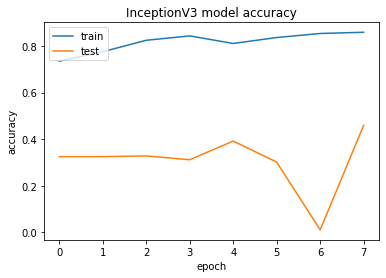

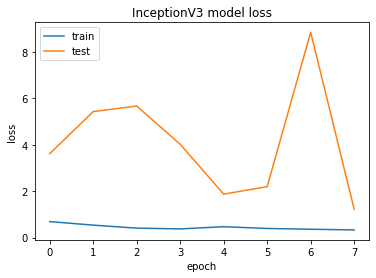

In [17]:
# summarize history for accuracy
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('InceptionV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('InceptionV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
inception_model.load_weights("./weights/inception.hdf5")

In [28]:
score = inception_model.evaluate(test_tensors, y_test, verbose=0)
score[1]

0.6630265116691589

### 2.3 Ensemble architecture

In [29]:
# Model 1
mobilenet_model = load_model("./weights/mobilenet.hdf5")

In [30]:
# Model 2
inception_model = load_model("./weights/inception.hdf5")

In [31]:
models = [mobilenet_model, inception_model]

In [32]:
model_input = Input(shape=models[0].input_shape[1:])

In [33]:
def ensemble(models, model_input):
    """
    Ensembling multiple models.
    """
    # Getting the output of all models
    outputs = [model(model_input) for model in models]
    # Avereging all outputs to one
    y = keras.layers.average(outputs)
    # Making a new model with one input and avereged output
    model = Model(inputs=model_input, outputs=y, name='ensemble')
    
    model.summary()
    
    return model

In [34]:
ensemble_model = ensemble(models, model_input)

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 4)            4018372     input_4[0][0]                    
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 4)            23116580    input_4[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 4)            0           functional_5[0][0]               
                                                                 functional_1[0][0]        

In [35]:
image_to_predict = path_to_tensor(X_test[0]).astype('float32')/255.0
ensemble_model.predict(image_to_predict)

array([[2.7777846e-03, 6.1214302e-04, 7.9817402e-01, 1.9843598e-01]],
      dtype=float32)

In [36]:
y_test[0]

array([0., 0., 1., 0.])

In [37]:
ensemble_model.save("./weights/ensemble_model.hdf5")

## 3. Predicting and Evaluating Ensemble

In [38]:
# Importing Libraries
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def compute_roc(y_true, y_score):
    """ 
    Computing the "Receiving Operating Characteristic curve" and area
    """
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score) 
    auroc = auc(false_positive_rate, true_positive_rate) 
    return false_positive_rate, true_positive_rate, auroc

In [40]:
def plot_roc(y_true, y_score):
    '''
    Plotting the "Receiving Operating Characteristic curve"
    '''
    false_positive_rate, true_positive_rate, auroc = compute_roc(y_true, y_score)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(false_positive_rate, true_positive_rate, 
             color='darkorange',lw=2, 
             label='ROC curve (area = {:.2f})'.format(auroc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic example', fontsize=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

In [41]:
def pos_neg_measurement(y_true, y_score):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score)):
        if y_true[i] == y_score[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score[i] == 1) and (y_true[i] != y_score[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score[i] == 0) and (y_true[i] != y_score[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [42]:
# Compute the test set predictions
length_of_test = len(y_test)

y_true = y_test
y_score = []
for index in tqdm(range(length_of_test)):
    image_to_predict = path_to_tensor(X_test[index]).astype('float32')/255.0
    prob = ensemble_model.predict(image_to_predict)
    if(np.argmax(prob)==0):
        y_score.append([1.0, 0, 0, 0])
    elif(np.argmax(prob)==1):
        y_score.append([0, 1.0, 0, 0])
    elif(np.argmax(prob)==2):
        y_score.append([0, 0, 1.0, 0])
    else:
        y_score.append([0, 0, 0, 1.0])

correct = np.array(y_true)==np.array(y_score)

100%|██████████| 641/641 [01:03<00:00, 10.15it/s]


In [43]:
def evaluate_col(column_name):
    
    y_true2 = []
    y_score2 = []
    
    # Getting the score and true value for the respective column
    for i_row in tqdm(range(len(y_true))):
        y_true2.append(y_true[i_row][column_name])
        y_score2.append(y_score[i_row][column_name])

    # Plotting the "Receiving Characteristic curve"
    plot_roc(y_true2, y_score2)
    
    # Getting the true postives, true negatives, false positives, false negatives
    true_positive, false_positive, true_negative, false_negative=pos_neg_measurement(y_true2, y_score2)
    positives_negatives = [[true_positive, false_negative],
                           [false_positive, true_negative]]
    
    # Plotting the heat map
    sns.set()
    l =  np.array([['True positive: ' + str(true_positive),
                     'False positive: ' + str(false_positive)],
                    ['False negative: ' + str(false_negative),
                     'True negative: ' + str(true_negative)]])
    plt.figure(figsize = (10, 7))
    sns.heatmap(positives_negatives, annot = l, linewidths = 0.1, fmt="", cmap = 'Blues')

    # Sensitivity | Recall | hit rate | true positive rate (TPR)
    sensitivity = true_positive / (true_positive + false_negative)
    print("Sensitivity: ", sensitivity)

    # Specificity | selectivity | true negative rate (TNR)
    specifity = true_negative / (true_negative + false_negative)
    print("Specifity: ", specifity)

    # Precision | positive predictive value (PPV)
    precision = true_positive / (true_positive + false_positive)
    print("Precision: ", precision)

    # Negative predictive value (NPV)
    npv = true_negative / (true_negative + false_negative)
    print("Negative predictive value: ", npv)

    # Accuracy 
    accuracy = (true_positive + true_negative) / (true_positive + false_positive + true_negative + false_negative)
    print("Accuracy: ", accuracy)

### 3.1 Predicting "Normal"

In [44]:
plt.style.available
plt.style.use("seaborn-white")

100%|██████████| 641/641 [00:00<00:00, 641199.35it/s]


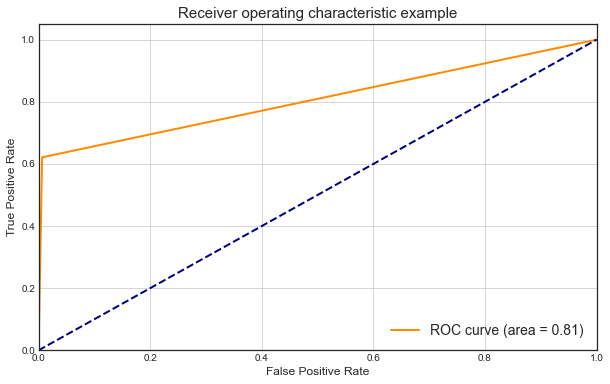

Sensitivity:  0.621301775147929
Specifity:  0.8799249530956847
Precision:  0.9722222222222222
Negative predictive value:  0.8799249530956847
Accuracy:  0.8954758190327613


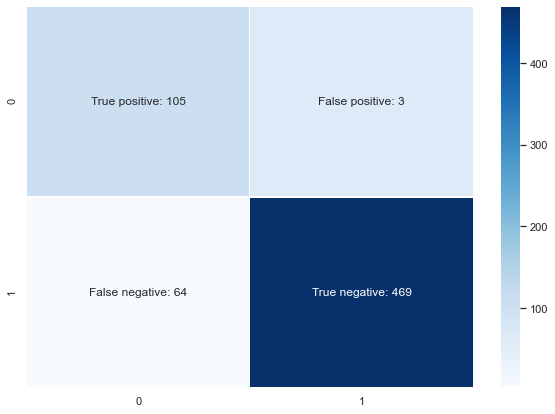

In [45]:
evaluate_col(0)

### 3.2 Predicting "Covid-19"

100%|██████████| 641/641 [00:00<00:00, 641352.31it/s]


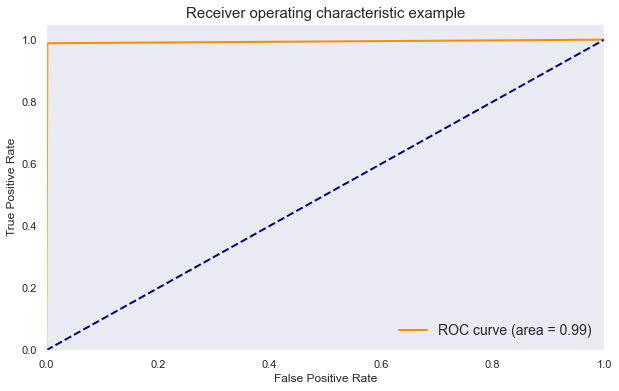

Sensitivity:  0.9885714285714285
Specifity:  0.9957173447537473
Precision:  0.9942528735632183
Negative predictive value:  0.9957173447537473
Accuracy:  0.9953198127925117


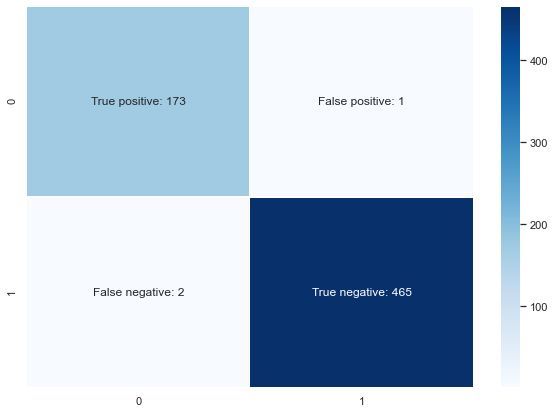

In [46]:
evaluate_col(1)

### 3.3 Predicting "Bacterial Pneumonia" 

100%|██████████| 641/641 [00:00<00:00, 637247.89it/s]


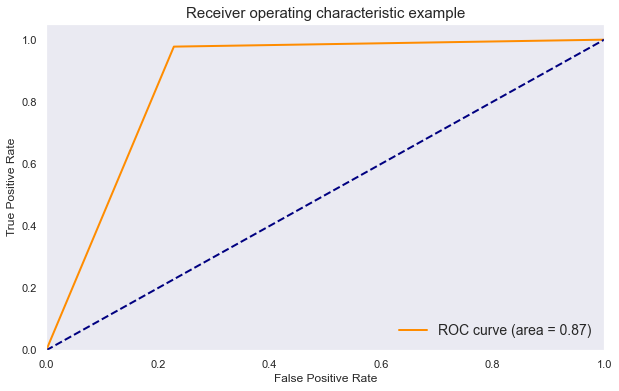

Sensitivity:  0.9776119402985075
Specifity:  0.9923857868020305
Precision:  0.5303643724696356
Negative predictive value:  0.9923857868020305
Accuracy:  0.8143525741029641


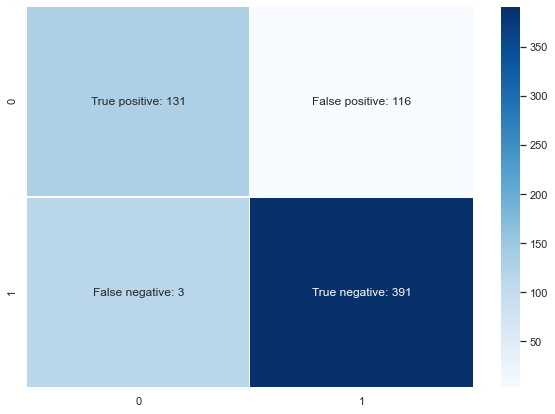

In [47]:
evaluate_col(2)

### 3.4 Predicting "Viral Pneumonia"

100%|██████████| 641/641 [00:00<00:00, 640893.65it/s]


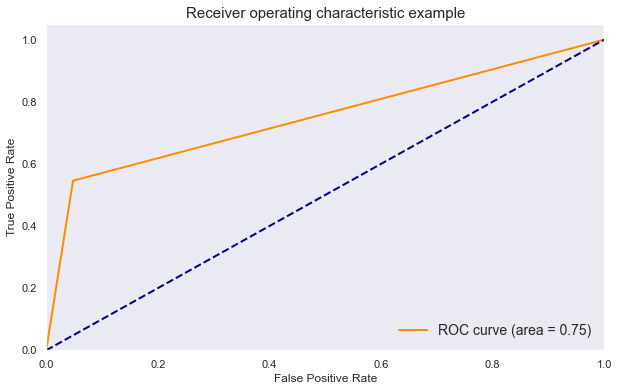

Sensitivity:  0.5460122699386503
Specifity:  0.8601134215500945
Precision:  0.7946428571428571
Negative predictive value:  0.8601134215500945
Accuracy:  0.8486739469578783


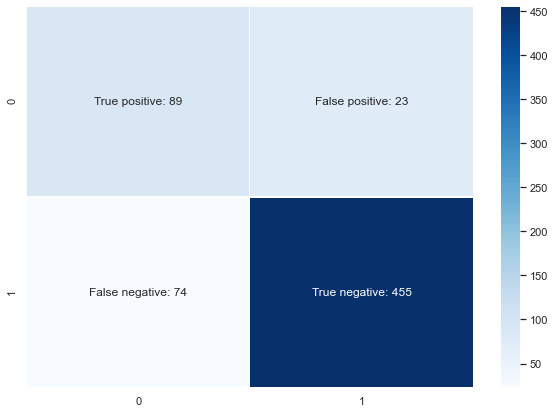

In [48]:
evaluate_col(3)

### 3.5 Accuracy of the whole dataset

In [49]:
y_score_2 = [] 
y_true_2 = []

for index in tqdm(range(len(y_score))):
    if np.array_equal(y_score[index], y_test[index]): 
        y_score_2.append(1)
    else:
        y_score_2.append(0)

100%|██████████| 641/641 [00:00<00:00, 128252.10it/s]


In [50]:
accuracy = np.sum(y_score_2) / len(y_score_2)
print("Total accuracy: ", accuracy)

Total accuracy:  0.7769110764430577


## 4. Localization

### 4.1 Grad-CAM visualization

In [51]:
import scipy
import cv2

In [52]:
def getting_two_layer_weights(path_model_weight):
    # The model

    # Imprting the model
    from keras.applications.mobilenet import MobileNet

    # Pre-build model
    base_model = MobileNet(include_top = False, weights = None, input_shape = (256, 256, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units = 512, activation = 'relu')(x)
    x = Dense(units = 512, activation = 'relu')(x)
    output = Dense(units = 4, activation = 'softmax')(x)

    # Creating the whole model
    model = Model(base_model.input, output)
    #model.summary()

    # Compiling the model
    model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    # loading the weights
    model.load_weights(path_model_weight)
    
    # Getting the AMP layer weight
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    
    # Extracting the wanted output
    mobilenet_model = Model(inputs = model.input, outputs = (model.layers[-5].output, model.layers[-1].output))
    
    return mobilenet_model, all_amp_layer_weights

In [53]:
def CAM_func(img_path, model, all_amp_layer_weights):
    # Getting filtered images from last convolutional layer + model prediction output
    last_conv_output, predictions = model.predict(path_to_tensor(img_path)) 
    
    # Eliminating dimensions of one    
    last_conv_output = np.squeeze(last_conv_output)
    
    # Model's prediction
    predicted_class = np.argmax(predictions)
    
    # Bilinear upsampling (resize each image to size of original image)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 0.5), order = 1)  # dim from (16, 16, 1024) to (512, 512, 1024)
    
    # Getting the AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, predicted_class] # dim: (1024,)    
    
    # CAM for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult, amp_layer_weights) # dim: 512 x 512

    # Return class activation map (CAM)
    return final_output, predicted_class


In [54]:
def plot_CAM(img_path, ax, model, all_amp_layer_weights):
    # Loading the image / resizing to 512x512 / Converting BGR to RGB
    #im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (512, 512))
    im = path_to_tensor(img_path).astype("float32")/255.
    
    # Plotting the image
    ax.imshow(im.squeeze(), vmin=0, vmax=255)
    
    # Getting the class activation map
    CAM, pred = CAM_func(img_path, model, all_amp_layer_weights)
    
    CAM = (CAM - CAM.min()) / (CAM.max() - CAM.min())
    
    # Plotting the class activation map
    ax.imshow(CAM, cmap = "jet", alpha = 0.2, interpolation='nearest', vmin=0, vmax=1)
    ax.xticks([])
    ax.yticks([])
    ax.grid(False)

In [55]:
img_path = X_test[25]

In [56]:
mobilenet_model, all_amp_layer_weights = getting_two_layer_weights(path_model_weight="./weights/mobilenet.hdf5")

In [57]:
final_output, predicted_class = CAM_func(img_path, mobilenet_model, all_amp_layer_weights)

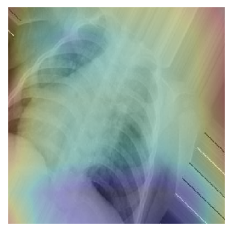

In [58]:
plot_CAM(img_path, plt, mobilenet_model, all_amp_layer_weights)

In [59]:
image_to_predict = path_to_tensor(X_test[25]).astype('float32')/255.0
pred = ensemble_model.predict(image_to_predict)

In [60]:
pred

array([[0.00270811, 0.0078093 , 0.844369  , 0.14511362]], dtype=float32)

In [61]:
y_test[25]

array([0., 0., 1., 0.])

([], [])

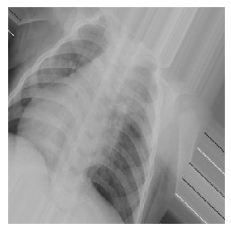

In [62]:
img = np.squeeze(image_to_predict)
plt.imshow(img)
plt.grid(False)
plt.xticks([])
plt.yticks([])

## Final Output

Image uploaded sucessfully!..(1/5)
Image preprocessed sucessfully!..(2/5)
Image localization calculated sucessfully!..(3/5)


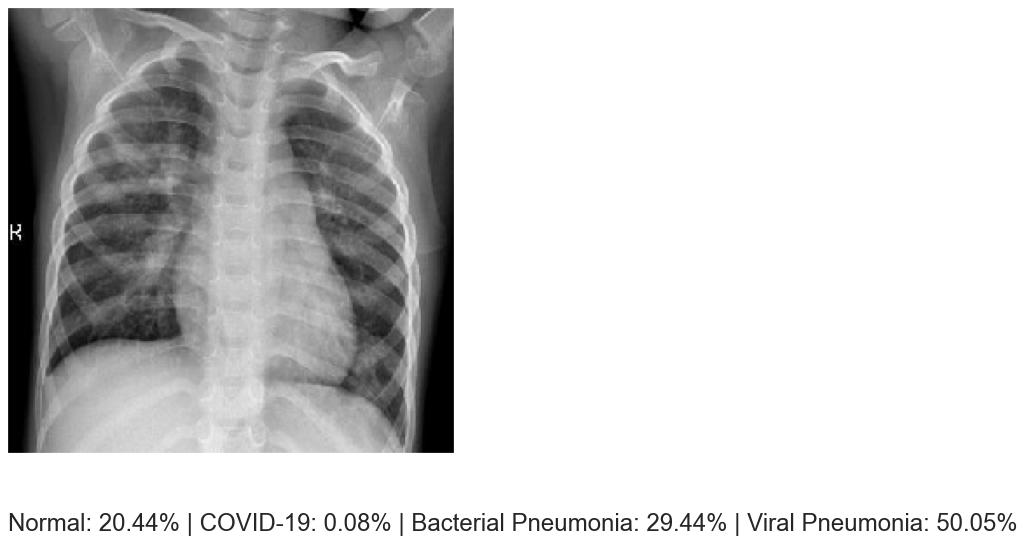

Image plotted sucessfully!..(4/5)
Localized image plotted sucessfully!..(5/5)


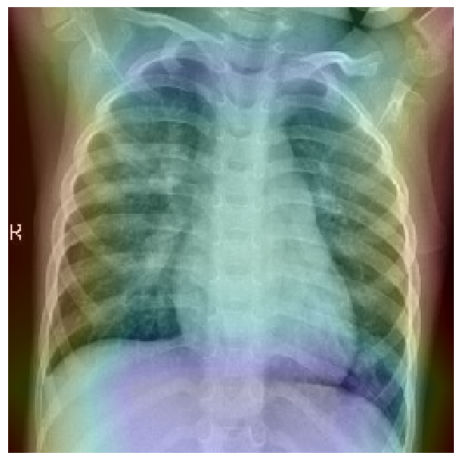

In [63]:
img_path = X_test[205]

# Getting the image tensor
image_to_predict = path_to_tensor(img_path).astype('float32')/255
image_to_plot = path_to_tensor(img_path)

print("Image uploaded sucessfully!..(1/5)")
print("Image preprocessed sucessfully!..(2/5)")

# Getting the weights of last activation and last dense for localization
ensembled_model, all_amp_layer_weights = getting_two_layer_weights(path_model_weight="./weights/mobilenet.hdf5")

# Calculating the localization
final_output, predicted_class = CAM_func(img_path, ensembled_model, all_amp_layer_weights)

print("Image localization calculated sucessfully!..(3/5)")

# Predicting the image
prediction = ensemble_model.predict(image_to_predict)
prediction_final = "Normal: " + str(np.round(prediction[0][0]*100, decimals = 2)) + "%" + \
                   " | COVID-19: " + str(np.round(prediction[0][1]*100, decimals = 2)) + "%" + \
                   " | Bacterial Pneumonia: " + str(np.round(prediction[0][2]*100, decimals = 2)) + "%" + \
                   " | Viral Pneumonia: " + str(np.round(prediction[0][3]*100, decimals = 2)) + "%"

# Canvas initialization
plt.figure(figsize = (8, 10))

# First image
#plt.subplot(121)
plt.imshow(image_to_predict.squeeze())
plt.xticks([])
plt.yticks([])
plt.text(0, 300, prediction_final, fontsize = 24)
plt.show()

print("Image plotted sucessfully!..(4/5)")

# Second image
#plt.subplot(122)

# Plotting the image
plt.figure(figsize=(8, 10))
plot_CAM(img_path, plt, mobilenet_model, all_amp_layer_weights)

print("Localized image plotted sucessfully!..(5/5)")

plt.show()

In [64]:
y_test[205]

array([0., 0., 0., 1.])